<a href="https://colab.research.google.com/github/SVGS-EVA4/Phase2/blob/master/S7-Variational_AutoEncoders/VAE_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Code taken from https://vxlabs.com/2017/12/08/variational-autoencoder-in-pytorch-commented-and-annotated/

## **Degrade Torch and TorchVision Version(which is compatible in deployment)**

In [1]:
!pip install torch==1.5.0 torchvision==0.6.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html


## **Mount the drive**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!cp '/content/drive/My Drive/E4P2/cars_dataset/cars_dataset.zip' '/content'

In [64]:
!cp -r '/content/results' '/content/drive/My Drive/E4P2/cars_dataset'

## **Import required modules**

In [4]:
import os
import torch
import torch.utils.data
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from torchvision.utils import save_image


## **Configurations**

In [5]:
# Configurations

CUDA = True
SEED = 1
BATCH_SIZE = 128
LOG_INTERVAL = 10
max_epochs = 500
IMAGE_DIM = (128, 128, 3)
capacity = 64
latent_dims = 40

# connections through the autoencoder bottleneck
# in the pytorch VAE example, this is 20
ZDIMS = 20


# **Extract dataset from zip file**

In [6]:
from zipfile import ZipFile 
if 'cars_dataset' in os.listdir('/content'):
  print('Dataset already unzipped')
else:
  with ZipFile('/content/cars_dataset.zip', 'r') as zip_file: 
    print('Unzipping dataset')
    zip_file.extractall() 
    print('Done!')

Dataset already unzipped


## **Data Set**

In [7]:
from torch.utils.data import Dataset
import random
import glob
from PIL import Image

def CarsDataset(data_path='',train_transform=None,test_transform=None,split=70):
  fpaths = sorted(glob.glob(os.path.join(data_path, '*.jpg')))
  random.shuffle(fpaths)
  train_len = len(fpaths)*split//100
  train = CARS( file_paths= fpaths[:train_len], transform=train_transform)
  test = CARS( file_paths= fpaths[train_len:], transform=test_transform)
  return train,test

class CARS(Dataset):

    def __init__(self, file_paths, transform=None):

        self.transform = transform
        self.fpaths = file_paths

    def __getitem__(self, idx):
        img = self.transform(Image.open(self.fpaths[idx]))
        return img

    def __len__(self):
        return len(self.fpaths)

## **Transformations**

In [8]:
transform = transforms.Compose([transforms.Resize((IMAGE_DIM[0],IMAGE_DIM[1])),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
                               ]
)
train_set,test_set = CarsDataset(data_path='/content/cars_dataset/', train_transform=transform,test_transform=transform)

## **Data Loader**

In [10]:
def load(train_set,test_set,seed=1,batch_size=128,num_workers=4,pin_memory=True):
	
	SEED = 1

	# CUDA?
	cuda = torch.cuda.is_available()


	# For reproducibility
	torch.manual_seed(SEED)

	if cuda:
			torch.cuda.manual_seed(SEED)

	# dataloader arguments - something you'll fetch these from cmdprmt
	dataloader_args = dict(shuffle=True, batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory) if cuda else dict(shuffle=True, batch_size=64)

	trainloader = torch.utils.data.DataLoader(train_set, **dataloader_args)
	testloader = torch.utils.data.DataLoader(test_set, **dataloader_args)


	return  trainloader, testloader

In [11]:
train_loader,test_loader = load(train_set,test_set,batch_size=BATCH_SIZE)

# **Sample Data Set disply**

shape: torch.Size([128, 3, 128, 128])


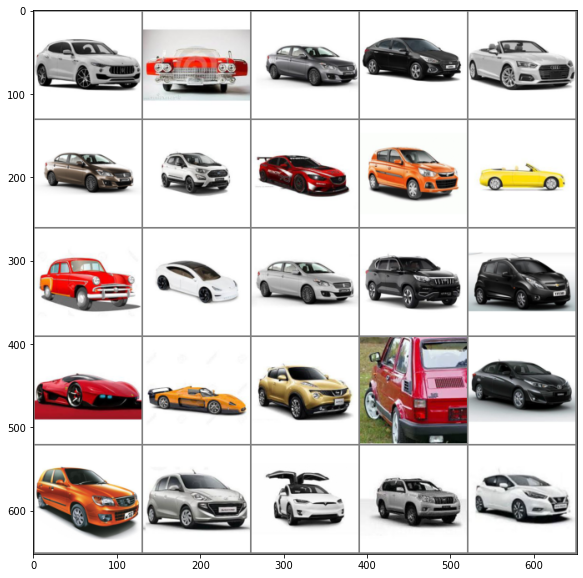

In [124]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
		



def show_random_images(dataset):

	# get some random training images
	dataiter = iter(dataset)
	images = dataiter.next()

	img_list = range(25)

	# show images
	print('shape:', images.shape)
	imshow(torchvision.utils.make_grid(images[img_list], nrow = 5))
   
show_random_images(train_loader)

## **VAE Architecture**

In [13]:
class VAE(nn.Module):
    def __init__(self, IMAGE_DIM, in_channel=3, out_channel=3, latent_size=128):
        super(VAE, self).__init__()
        assert IMAGE_DIM[0] % 2**4 == 0, 'Should be divided 16'
        self.init_dim = (IMAGE_DIM[0] // 2**4, IMAGE_DIM[1] // 2**4)  
        self.encode = nn.Sequential(
            # Conv-1 -> 128 -> 64
            nn.Conv2d(in_channel, 512, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            # Conv-2 -> 64 -> 32
            nn.Conv2d(512, 256, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            # Conv-3 -> 32 -> 16
            nn.Conv2d(256, 128, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # Conv-4 -> 16 -> 8
            nn.Conv2d(128, 128, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # Conv-5 -> 8 -> 4
            nn.Conv2d(128, 128, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # Conv-6 -> 4 -> 2
            nn.Conv2d(128, 128, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1), # Adaptive Avg Pool 2x2x100 -> 1x1x100
        )        
        self.fc_encode = nn.Sequential(
            # reshape input, 128 -> 100
            nn.Linear(128, latent_size),
            #nn.Sigmoid(),
        )
        self.fc_decode = nn.Sequential(
            nn.Linear(latent_size, self.init_dim[0]*self.init_dim[1]*32),
            nn.ReLU(),
        ) # 100 -> 2048
        self.decode = nn.Sequential(
            nn.Conv2d(32, 32, 3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            # 2048 -> 8x8x32    
            nn.ConvTranspose2d(32, 256, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            # 8x8x32 -> 16x16x256
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # 16x16x256 -> 32x32x128
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # 32x32x128 -> 64x64x64                   
            nn.ConvTranspose2d(64, out_channel, 4, stride=2, padding=1, bias=False),
            # 64x64x64 -> 128x128x3
            nn.Sigmoid(),
        )

    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling
        return sample   

    def forward(self, x):
        # encoding
        x = self.encode(x)
        x = x.view(x.size(0), -1)
        x = self.fc_encode(x)

        # get `mu` and `log_var`
        mu      = x
        log_var = x
        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var)

        # decoding
        x = z.view(z.size(0), -1)
        x = self.fc_decode(x)
        x = x.view(x.size(0), 32, self.init_dim[0], self.init_dim[1])
        x = self.decode(x)
        return x, mu, log_var

In [14]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [30]:
use_cuda = torch.cuda.is_available()
DEVICE = torch.device("cuda" if use_cuda else "cpu")
model = VAE(IMAGE_DIM, in_channel=IMAGE_DIM[-1],out_channel=IMAGE_DIM[-1]).to(DEVICE)
model.apply(weights_init)
print('done!')

done!


In [31]:
summary(model, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 512, 64, 64]          13,824
       BatchNorm2d-2          [-1, 512, 64, 64]           1,024
              ReLU-3          [-1, 512, 64, 64]               0
            Conv2d-4          [-1, 256, 32, 32]       1,179,648
       BatchNorm2d-5          [-1, 256, 32, 32]             512
              ReLU-6          [-1, 256, 32, 32]               0
            Conv2d-7          [-1, 128, 16, 16]         294,912
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
           Conv2d-10            [-1, 128, 8, 8]         147,456
      BatchNorm2d-11            [-1, 128, 8, 8]             256
             ReLU-12            [-1, 128, 8, 8]               0
           Conv2d-13            [-1, 128, 4, 4]         147,456
      BatchNorm2d-14            [-1, 12

## **Train the model**

In [32]:
div_factor = 25

In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
import random
from time import time
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, imsave
import cv2
import torchvision
import torchvision.utils as vutils 

# # class for Calculating and storing training losses and training accuracies of model for each batch per epoch ## 
class Training:

      def final_loss(self, mse_loss, mu, logvar, batch_sz, channels, img_dim1, img_dim2):
          """
           This function will add the reconstruction loss (BCELoss) and the KL-Divergence.
           KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
           :param bce_loss: recontruction loss
           :param mu: the mean from the latent vector
           :param logvar: log variance from the latent vector
          """
          MSE = mse_loss 
          KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
          KLD = KLD /(batch_sz * channels * img_dim1 * img_dim2)
          return MSE + KLD    

      def get_sample_image(self, reconstructed_img):
          """
          modify sample images for saving purpose
          """
          cnt = reconstructed_img.shape
          sample_img = reconstructed_img.view(cnt, 3, 128, 128).permute(0, 2, 3, 1)    #Modify axes to (32, 28, 28, 3) via permute. 32 -> batch_size
          result = (sample_img.detach().cpu().numpy()+1)/2.
          return result
      
      def train(self,model, device, train_loader, optimizer, epoch, max_epoch, criterion):
         

          
          model.train()
          train_loss = 0 
          
          
          for batch_idx, data in enumerate(train_loader):
               
              images =  data.to(device)      # Moving images and correspondig labels to GPU
              optimizer.zero_grad()     # Zeroing out gradients at start of each batch so that backpropagation won't take accumulated value
                       
              reconstructed_img, mu, logvar = model(images) # Calling CNN model to predict the images
            
              mse_loss    = criterion(reconstructed_img, images)
              batch_sz, channels, img_dim1, img_dim2 = images.shape[0], images.shape[1], images.shape[2], images.shape[3]
              train_loss1  = self.final_loss(mse_loss, mu, logvar, batch_sz, channels, img_dim1, img_dim2)          

              # Backpropagation
              train_loss1.backward()
              optimizer.step()  
              train_loss += train_loss1.item()       
              
          return train_loss/len(train_loader) 

      def test(self,model, device, test_loader, optimizer, epoch, max_epoch, criterion):
       
            
            model.eval()      
          
            test_loss =  0
            
            for batch_idx, data in enumerate(test_loader):
                
                images =  data.to(device)      # Moving images and correspondig labels to GPU
                
                        
                reconstructed_img, mu, logvar = model(images) # Calling CNN model to predict the images
              
                mse_loss    = criterion(reconstructed_img, images)
                batch_sz, channels, img_dim1, img_dim2 = images.shape[0], images.shape[1], images.shape[2], images.shape[3]
                test_loss1  = self.final_loss(mse_loss, mu, logvar, batch_sz, channels, img_dim1, img_dim2)  
                
                test_loss += test_loss1.item()
                if epoch % div_factor==0:
                  if batch_idx==0:
                    n = min(data.size(0), 8)
                    # for the first 128 batch of the epoch, show the first 8 input digits
                    # with right below them the reconstructed output digits
                    comparison = torch.cat([images[:n],reconstructed_img.view(BATCH_SIZE, 3, IMAGE_DIM[0], IMAGE_DIM[1])[:n]])
                    
                    save_image(comparison.data.cpu(),'results/reconstruction_' + str(epoch) + '.png', nrow=n)

            return test_loss/len(test_loader)        

                     


## **Initialise optimizer and loss**

In [34]:
# Dr Diederik Kingma: as if VAEs weren't enough, he also gave us Adam!
optimizer = optim.Adam(model.parameters(),  lr=0.001, betas=(0.5, 0.999))
criterion = nn.MSELoss()

In [35]:
if 'results' not in os.listdir('/content'):
  os.mkdir('results')



## **Train**

In [36]:
train_losses = []
test_losses = []

training = Training()
for epoch in range(max_epoch):

    train_loss = training.train(model,DEVICE,train_loader=train_loader,optimizer=optimizer ,epoch=epoch, max_epoch= max_epoch, criterion=criterion)   
    test_loss =  training.test(model,DEVICE,test_loader=test_loader,optimizer=optimizer ,epoch=epoch, max_epoch= max_epoch, criterion=criterion)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    if(epoch%25 == 0):
      print(f'Epoch: {epoch+1}/{max_epoch},  Train Loss: {train_loss:.6f}, Test Loss: {test_loss:.6f}')

Epoch: 1/500,  Train Loss: 0.396398, Test Loss: 0.409031
Epoch: 26/500,  Train Loss: 0.142306, Test Loss: 0.138110
Epoch: 51/500,  Train Loss: 0.129327, Test Loss: 0.142308
Epoch: 76/500,  Train Loss: 0.124719, Test Loss: 0.135590
Epoch: 101/500,  Train Loss: 0.119599, Test Loss: 0.134741
Epoch: 126/500,  Train Loss: 0.117490, Test Loss: 0.134476
Epoch: 151/500,  Train Loss: 0.115699, Test Loss: 0.133243
Epoch: 176/500,  Train Loss: 0.112583, Test Loss: 0.132245
Epoch: 201/500,  Train Loss: 0.109961, Test Loss: 0.131281
Epoch: 226/500,  Train Loss: 0.109188, Test Loss: 0.128647
Epoch: 251/500,  Train Loss: 0.108284, Test Loss: 0.132767
Epoch: 276/500,  Train Loss: 0.106074, Test Loss: 0.131730
Epoch: 301/500,  Train Loss: 0.104306, Test Loss: 0.136042
Epoch: 326/500,  Train Loss: 0.103554, Test Loss: 0.132995
Epoch: 351/500,  Train Loss: 0.102422, Test Loss: 0.132401
Epoch: 376/500,  Train Loss: 0.101564, Test Loss: 0.133356
Epoch: 401/500,  Train Loss: 0.100173, Test Loss: 0.127866
Ep

## **Results after training for 500 epochs**

In [49]:

import matplotlib.pyplot as plt
import numpy as np

# obtain one batch of test images

def display_result(test_loader, DEVICE, model):
  dataiter = iter(test_loader)
  images= dataiter.next()
  images_ = images.to(DEVICE)

  # get sample outputs
  output = model(images_)
  output = output[0].cpu().detach().numpy()

  # plot the first ten input images and then reconstructed images
  fig, axes = plt.subplots(nrows=2, ncols=10,figsize=(25,4))

  # input images on top row, reconstructions on bottom
  for images, row in zip([images, output], axes):
      for img, ax in zip(images, row):
          img = np.array(img)
          img = np.transpose(img, (1,2,0))
          ax.imshow(img)
          ax.get_xaxis().set_visible(False)
          ax.get_yaxis().set_visible(False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

CPU times: user 834 ms, sys: 436 ms, total: 1.27 s
Wall time: 2.07 s


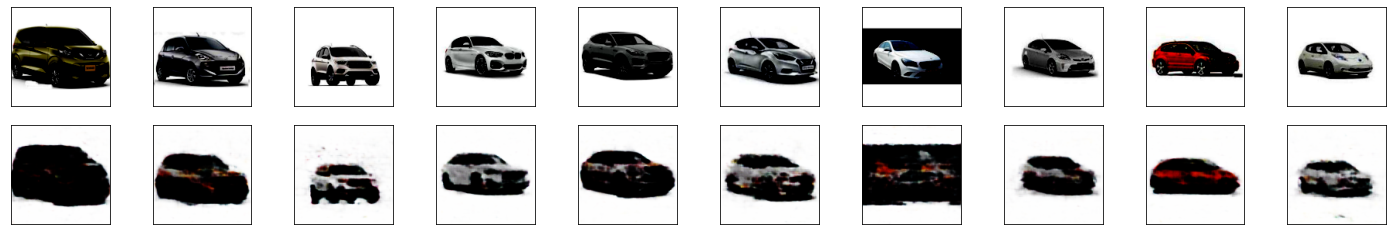

In [42]:
display_result(test_loader, DEVICE, model)


## **Train and Test Loss Visualisation from 500 epochs**

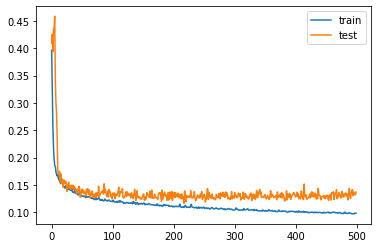

In [44]:
plt.plot(train_losses,label='train')
plt.plot(test_losses,label='test')
plt.legend()


## **Save the model**

In [46]:
path = '/content/drive/My Drive/E4P2/cars_dataset/VAE_models/VAEcheckpoint(500).pt'
state = {
            'epoch' : 500,
            'train_loss' :train_losses,
            'test_loss' : test_losses,
            'model_state_dict' : model.state_dict(),
            'optimizer_state_dict' :optimizer.state_dict(),
        }
torch.save(state, path)

In [47]:
%%time
max_epoch = 1000
for epoch in range(500, max_epoch):

    train_loss = training.train(model,DEVICE,train_loader=train_loader,optimizer=optimizer ,epoch=epoch, max_epoch= max_epoch, criterion=criterion)   
    test_loss =  training.test(model,DEVICE,test_loader=test_loader,optimizer=optimizer ,epoch=epoch, max_epoch= max_epoch, criterion=criterion)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    if(epoch%25 == 0):
      print(f'Epoch: {epoch+1}/{max_epoch},  Train Loss: {train_loss:.6f}, Test Loss: {test_loss:.6f}')

Epoch: 501/1000,  Train Loss: 0.097719, Test Loss: 0.133855
Epoch: 526/1000,  Train Loss: 0.096446, Test Loss: 0.136156
Epoch: 551/1000,  Train Loss: 0.097000, Test Loss: 0.130072
Epoch: 576/1000,  Train Loss: 0.095214, Test Loss: 0.131939
Epoch: 601/1000,  Train Loss: 0.095430, Test Loss: 0.130896
Epoch: 626/1000,  Train Loss: 0.094279, Test Loss: 0.135675
Epoch: 651/1000,  Train Loss: 0.094034, Test Loss: 0.128787
Epoch: 676/1000,  Train Loss: 0.093852, Test Loss: 0.126608
Epoch: 701/1000,  Train Loss: 0.094164, Test Loss: 0.133866
Epoch: 726/1000,  Train Loss: 0.093454, Test Loss: 0.125472
Epoch: 751/1000,  Train Loss: 0.092021, Test Loss: 0.130472
Epoch: 776/1000,  Train Loss: 0.092025, Test Loss: 0.141163
Epoch: 801/1000,  Train Loss: 0.091863, Test Loss: 0.147036
Epoch: 826/1000,  Train Loss: 0.091887, Test Loss: 0.127299
Epoch: 851/1000,  Train Loss: 0.090972, Test Loss: 0.136576
Epoch: 876/1000,  Train Loss: 0.090579, Test Loss: 0.132611
Epoch: 901/1000,  Train Loss: 0.090654, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

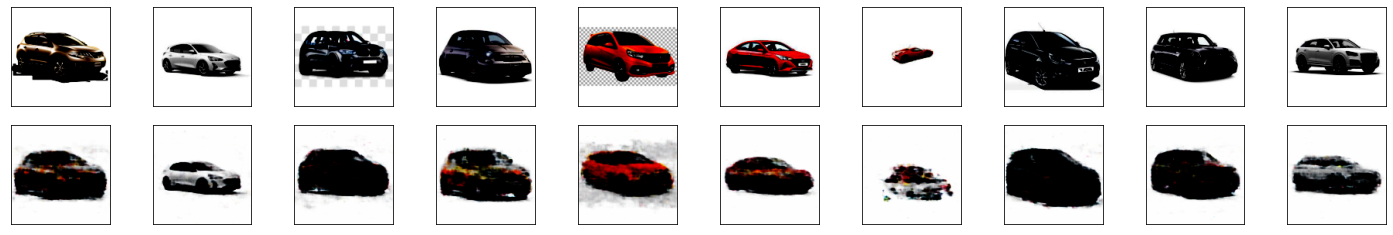

In [50]:
display_result(test_loader, DEVICE, model)

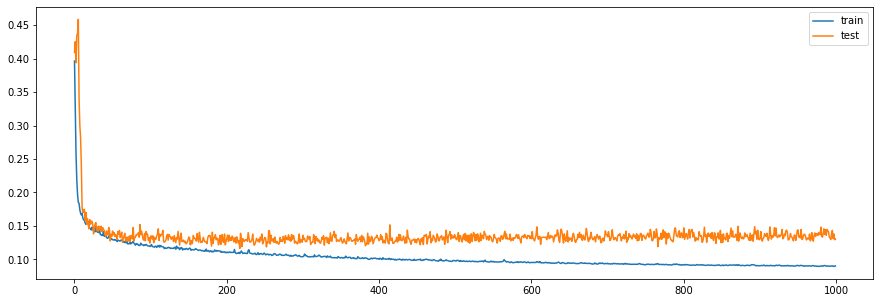

In [60]:
plt.figure(figsize=(15,5))
plt.plot(train_losses,label='train')
plt.plot(test_losses,label='test')
plt.legend()


In [62]:
path = '/content/drive/My Drive/E4P2/cars_dataset/VAE_models/VAEcheckpoint(1000).pt'
state = {
            'epoch' : 1000,
            'train_loss' :train_losses,
            'test_loss' : test_losses,
            'model_state_dict' : model.state_dict(),
            'optimizer_state_dict' :optimizer.state_dict(),
        }
torch.save(state, path)

In [65]:
optimizer.param_groups[0]['lr'] = 0.0001

In [66]:
%%time
max_epoch = 1300
for epoch in range(1000, max_epoch):

    train_loss = training.train(model,DEVICE,train_loader=train_loader,optimizer=optimizer ,epoch=epoch, max_epoch= max_epoch, criterion=criterion)   
    test_loss =  training.test(model,DEVICE,test_loader=test_loader,optimizer=optimizer ,epoch=epoch, max_epoch= max_epoch, criterion=criterion)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    if(epoch%25 == 0):
      print(f'Epoch: {epoch+1}/{max_epoch},  Train Loss: {train_loss:.6f}, Test Loss: {test_loss:.6f}')

Epoch: 1001/1300,  Train Loss: 0.089861, Test Loss: 0.136535
Epoch: 1026/1300,  Train Loss: 0.088642, Test Loss: 0.138208
Epoch: 1051/1300,  Train Loss: 0.088824, Test Loss: 0.134711
Epoch: 1076/1300,  Train Loss: 0.088676, Test Loss: 0.134947
Epoch: 1101/1300,  Train Loss: 0.089159, Test Loss: 0.132972
Epoch: 1126/1300,  Train Loss: 0.088725, Test Loss: 0.130447
Epoch: 1151/1300,  Train Loss: 0.088603, Test Loss: 0.128729
Epoch: 1176/1300,  Train Loss: 0.088593, Test Loss: 0.130544
Epoch: 1201/1300,  Train Loss: 0.088150, Test Loss: 0.138799
Epoch: 1226/1300,  Train Loss: 0.089041, Test Loss: 0.132495
Epoch: 1251/1300,  Train Loss: 0.088545, Test Loss: 0.135897
Epoch: 1276/1300,  Train Loss: 0.088386, Test Loss: 0.139917
CPU times: user 14min 30s, sys: 10min 46s, total: 25min 17s
Wall time: 36min 57s


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

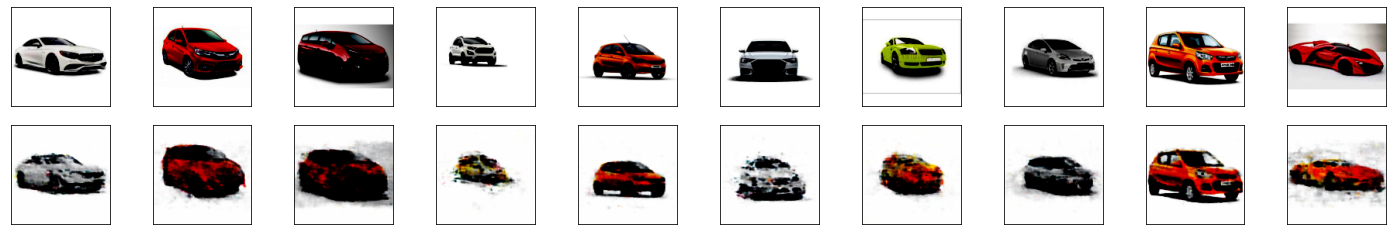

In [67]:
display_result(test_loader, DEVICE, model)

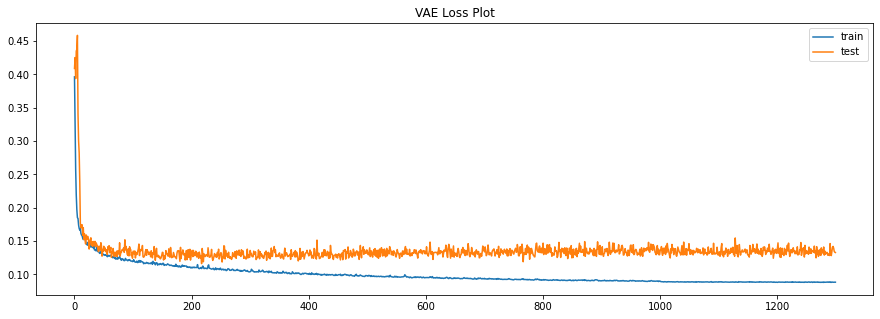

In [170]:
plt.figure(figsize=(15,5))
plt.plot(train_losses,label='train')
plt.plot(test_losses,label='test')
plt.legend()
plt.title("VAE Loss Plot")
plt.savefig('/content/drive/My Drive/E4P2/cars_dataset/VAE_models/loss_plot.jpg')


In [69]:
path = '/content/drive/My Drive/E4P2/cars_dataset/VAE_models/VAEcheckpoint(1300).pt'
state = {
            'epoch' : 1000,
            'train_loss' :train_losses,
            'test_loss' : test_losses,
            'model_state_dict' : model.state_dict(),
            'optimizer_state_dict' :optimizer.state_dict(),
        }
torch.save(state, path)

In [72]:

cars = []
for img_batch in test_loader:
    for i in range(img_batch.size(0)):
      cars.append(img_batch[i:i+1])
        # digits[label_batch[i]].append(img_batch[i:i+1])
    # if sum(len(d) for d in digits) >= 1000:
    #     break;


## **Interpolate in latent Space**

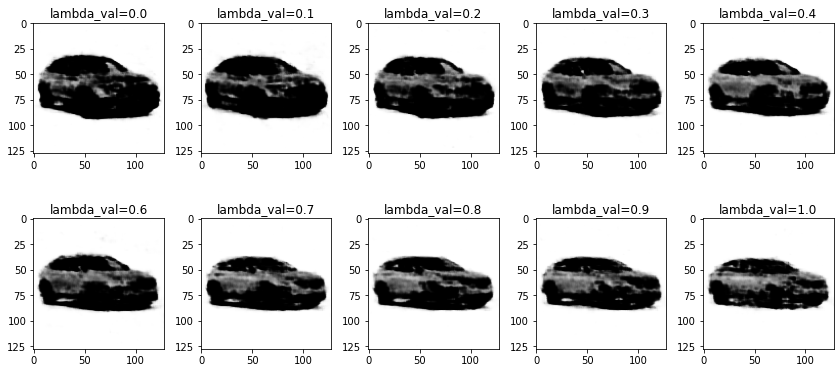

In [167]:
device = DEVICE
model.to(device)
init_dim = (IMAGE_DIM[0] // 2**4, IMAGE_DIM[1] // 2**4)
def interpolation(lambda1, model, img1, img2):
    
    with torch.no_grad():
    
        # latent vector of first image
        img1 = img1.to(device)
        
        _,latent_1, log_var1 = model(img1)
        
        # latent vector of second image
        img2 = img2.to(device)
        _,latent_2, log_var2 = model(img2)

        # interpolation of the two latent vectors
        inter_latent = lambda1* latent_1 + (1- lambda1) * latent_2
        # log_var = lambda1* log_var1 + (log_var1) * log_var2
       
        z = model.reparameterize(inter_latent, (log_var1 + log_var2)/2)
      
        x = z.view(z.size(0), -1)
        x = model.fc_decode(x)
        
        x = x.view(x.size(0), 32,init_dim[0], init_dim[1])
        inter_image = model.decode(x)
        # reconstruct interpolated image
        
        inter_image = inter_image.cpu()

        return inter_image
    
# sort part of test set by digit
# digits = [[] for _ in range(10)]


# interpolation lambdas
lambda_range=np.linspace(0,1,10)

fig, axs = plt.subplots(2, 5, figsize=(15, 6))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for ind, l in enumerate(lambda_range):
    inter_image=interpolation(float(l), model, cars[20], cars[30])
   
    inter_image = inter_image
    
    image = inter_image.numpy()
   
    axs[ind].imshow(image[0,0,:,:], cmap='gray')
    axs[ind].set_title('lambda_val='+str(round(l,1)))
plt.show()

## **Some Sample output images at different epochs**

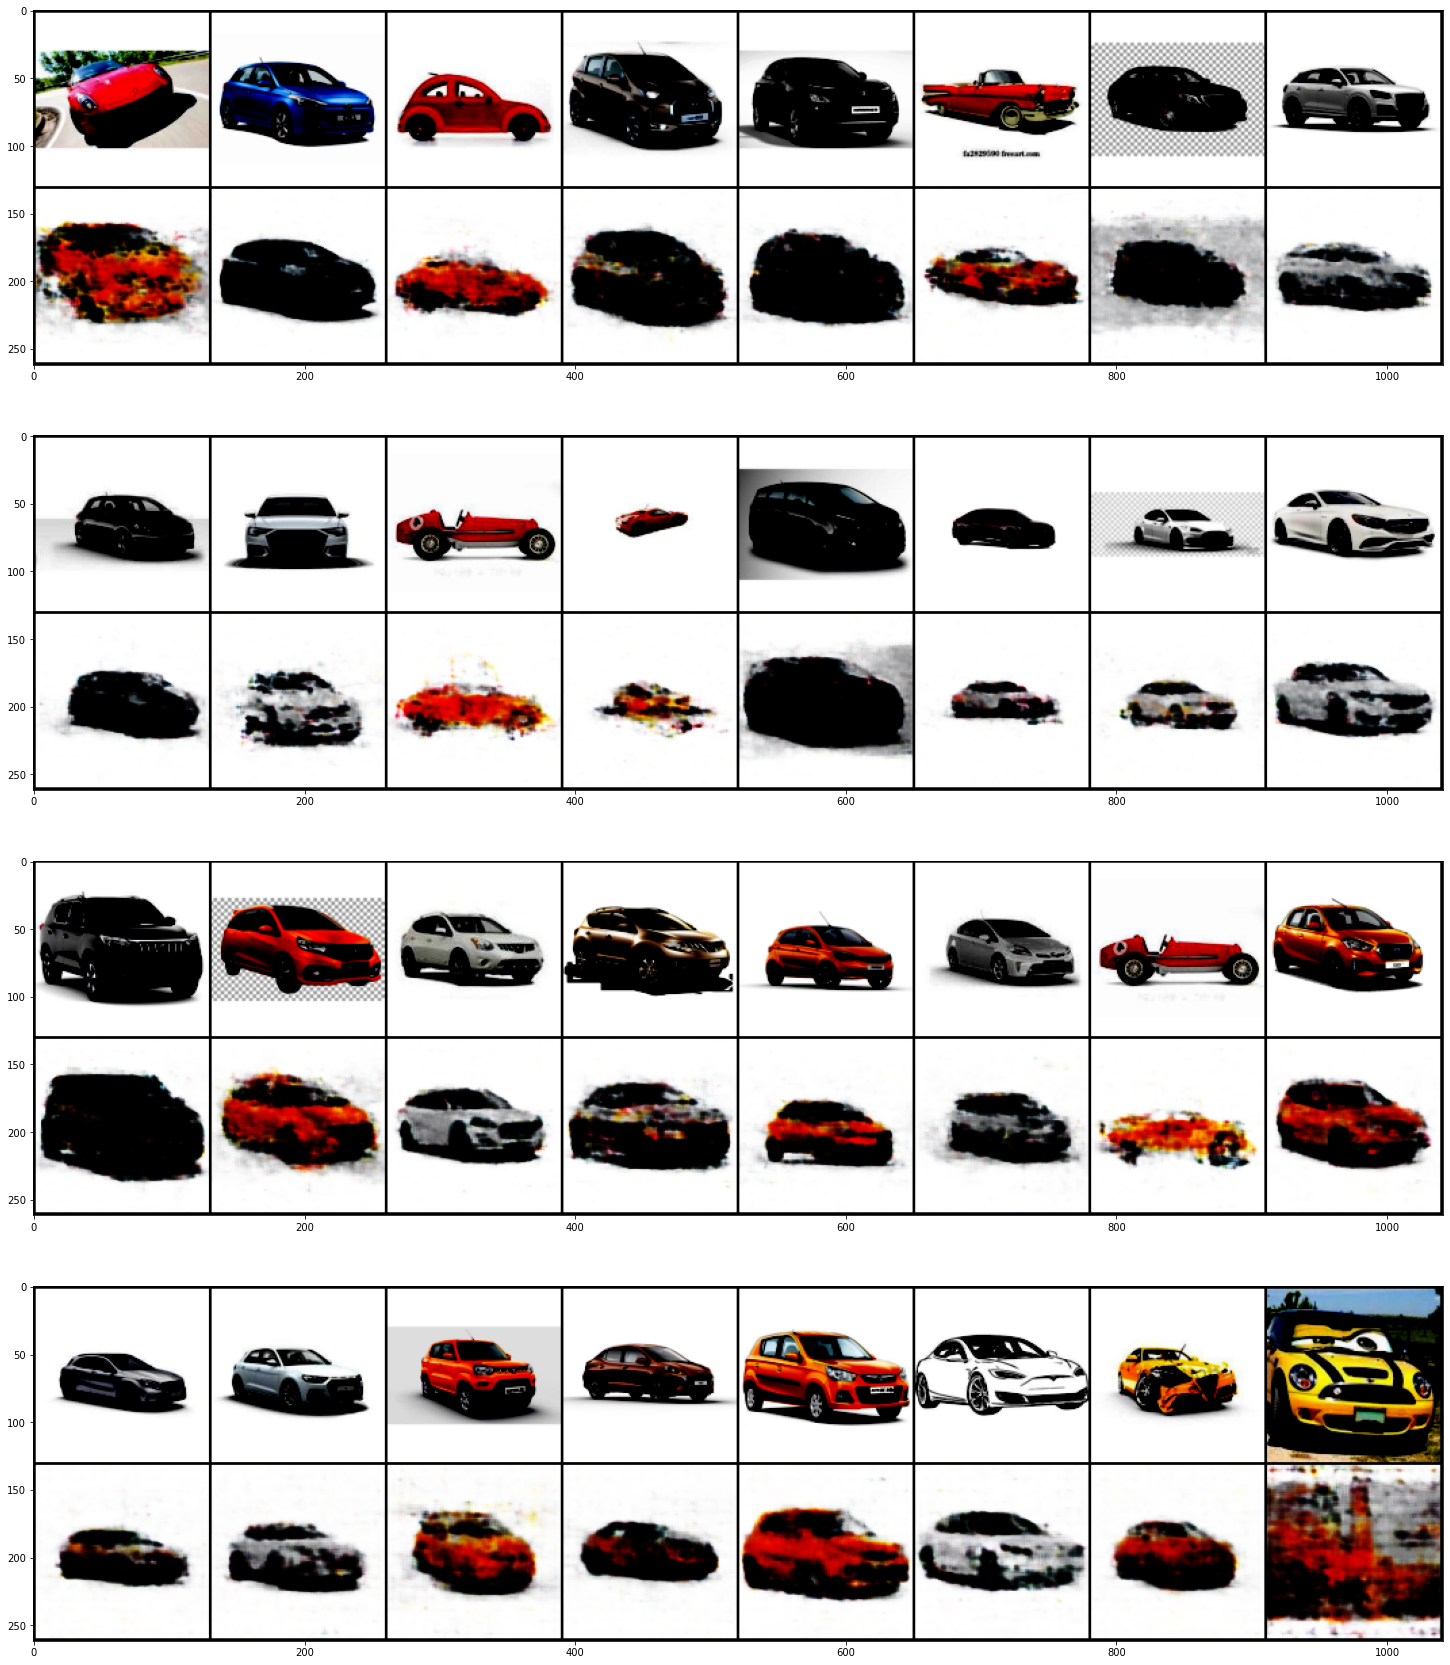

In [141]:
fig, ax = plt.subplots(4,1,figsize=(30,30))

ax[0].imshow(Image.open('/content/results/reconstruction_1275.png'))
ax[1].imshow(Image.open('/content/results/reconstruction_1200.png'))
ax[2].imshow(Image.open('/content/results/reconstruction_1000.png'))
ax[3].imshow(Image.open('/content/results/reconstruction_500.png'))

## **Traced Model**

In [165]:
model.to('cpu')
model.eval()
traced_model = torch.jit.trace(model, torch.randn(1,3,128,128))
traced_model.save('/content/drive/My Drive/E4P2/cars_dataset/VAE_models/vae_traced_model.pt')

/usr/local/lib/python3.6/dist-packages/torch/jit/__init__.py:1037: TracerWarning: Trace had nondeterministic nodes. Did you forget call .eval() on your model? Nodes:
	%eps : Float(1, 128) = aten::randn_like(%std, %328, %329, %330, %331, %332) # <ipython-input-13-8ffb7cc41a09>:70:0
This may cause errors in trace checking. To disable trace checking, pass check_trace=False to torch.jit.trace()
  check_tolerance, _force_outplace, True, _module_class)
/usr/local/lib/python3.6/dist-packages/torch/jit/__init__.py:1037: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Not within tolerance rtol=1e-05 atol=1e-05 at input[0, 0, 36, 74] (0.8078776597976685 vs. 0.09899671375751495) and 38941 other locations (79.23%)
  check_tolerance, _force_outplace, True, _module_class)
